In [196]:
import numpy as np
import astropy.io as ast
from astropy.io import fits
import matplotlib.pyplot as plt
import os

#Global Variables
FOLDER = '20180424'
XMIN = 750
XMAX = 1350
YMIN = 1700
YMAX = 2300

In [197]:
def open_runlog(directory):
    for fname in os.listdir(directory):
        if 'runlog' in fname:
            info = np.loadtxt(directory + '/' + fname, dtype='str')
            r_fname = info[:,0]
            r_descr = info[:,1]
            r_filter = info[:,-1]
            r_int_time = info[:,-3]
            return r_fname, r_descr, r_filter, r_int_time

In [198]:
def sort(fname, descr, filters):
    bias, flat_r, flat_V, trans6_r, trans6_V, trans7_r, trans7_V, trans4_r, trans4_V = [],[],[],[],[],[],[],[],[]
    for i in range(len(fname)):
        if descr[i]=='Bias':
            bias.append(fname[i])
            
        elif descr[i]=='Sky':
            if filters[i]=='r':
                flat_r.append(fname[i])
            else:
                flat_V.append(fname[i])
                
        elif 'TRANS6' in descr[i]:
            if filters[i]=='r':
                trans6_r.append(fname[i])
            else:
                trans6_V.append(fname[i])
                
        elif descr[i]=='TRANS7':
            if filters[i]=='r':
                trans7_r.append(fname[i])
            else:
                trans7_V.append(fname[i])
            
        elif descr[i]=='TRANS4':
            if filters[i]=='r':
                trans4_r.append(fname[i])
            else:
                trans4_V.append(fname[i])
    return bias, flat_V, flat_r, trans6_r, trans6_V, trans7_r, trans7_V, trans4_r, trans4_V

In [199]:
def mean_bias(bias, directory):
    Bias = np.zeros((YMAX-YMIN, XMAX-XMIN))
    for filename in bias:
        hdul = fits.open(directory+'/r'+filename+'.fit') 
        im = hdul[4].data[YMIN:YMAX, XMIN:XMAX]
        hdul.close()
        im = im.astype(float)
        Bias += im
    Bias /= len(bias)
    return Bias

In [200]:
def mean_flat_norm(flat, directory):
    Flat = np.zeros((YMAX-YMIN, XMAX-XMIN))
    for filename in flat:
        hdul = fits.open(directory+'/r'+filename+'.fit') 
        
        im = hdul[4].data[YMIN:YMAX, XMIN:XMAX]
        exp_t = hdul[0].header['EXPTIME']
        hdul.close()
        im = im.astype(float)
        im /= (np.max(im)*exp_t)
        Flat += im
    Flat /= len(flat)
    return Flat

In [201]:
# Uses mean normalized 'flat' and mean 'bias' to give the reduced data of 'image' (array of filenames of fits files)
def reduc(image_fname, flat, bias, directory):
    sciences = []
    for filename in image_fname:
        hdul = fits.open(directory+'/r'+filename+'.fit') 
        im = hdul[4].data[YMIN:YMAX, XMIN:XMAX]
        exp_t = hdul[0].header['EXPTIME']
        im = im.astype(float)
        im -= bias
        im /= (flat*exp_t)
        sciences.append(im)
    return sciences

In [202]:
runlog_fname, runlog_descr, runlog_filter, runlog_int_time = open_runlog(FOLDER)
bias, flat_V, flat_r, trans6_r, trans6_V, trans7_r, trans7_V, trans4_r, trans4_V = sort(runlog_fname, runlog_descr, runlog_filter)
Bias = mean_bias(bias, FOLDER)
Flat_r = mean_flat_norm(flat_r, FOLDER)
Flat_V = mean_flat_norm(flat_V, FOLDER)
sciences7_r = reduc(trans7_r, Flat_r, Bias, FOLDER)
sciences7_V = reduc(trans7_V, Flat_V, Bias, FOLDER)
sciences6_r = reduc(trans6_r, Flat_r, Bias, FOLDER)
sciences6_V = reduc(trans6_V, Flat_V, Bias, FOLDER)
sciences4_r = reduc(trans4_r, Flat_r, Bias, FOLDER)
sciences4_V = reduc(trans4_V, Flat_V, Bias, FOLDER)

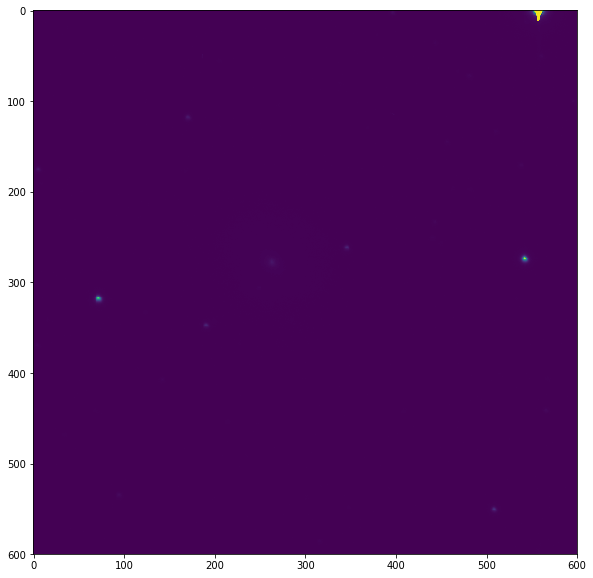

In [206]:
width = 10
height = 10
plt.figure(figsize=(width, height))

plt.imshow(sciences4_r[0])
plt.show()

In [204]:
fits.writeto('test.fit', sciences4_r[0], overwrite=True)